In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ieee = pd.read_csv("/content/drive/My Drive/Covid 19 India/ieee_extract.csv")
ait_train = pd.read_csv("/content/drive/My Drive/Covid 19 India/semeval_train.csv")
ait_dev = pd.read_csv("/content/drive/My Drive/Covid 19 India/semeval_dev.csv")
ait_test = pd.read_csv("/content/drive/My Drive/Covid 19 India/semval_test.csv")
senwave = pd.read_csv("/content/drive/My Drive/Covid 19 India/labeledEn.csv")

In [3]:
print("Length of IEEE Dataset = {}".format(len(ieee)))
print("Length of AIT Train Dataset = {}".format(len(ait_train)))
print("Length of AIT Dev Dataset = {}".format(len(ait_dev)))
print("Length of AIT Test Dataset = {}".format(len(ait_test)))
print("Length of Senwave Dataset = {}".format(len(senwave)))

Length of IEEE Dataset = 159312
Length of AIT Train Dataset = 6838
Length of AIT Dev Dataset = 886
Length of AIT Test Dataset = 3259
Length of Senwave Dataset = 10000


In [4]:
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1.245140e+18,A glass of wine keeps the corona away- DRAKE. ...,1,0,0,0,0,0,0,0,0,0,1
1,1.245140e+18,Can Anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1.245140e+18,Btw producers send me beats I’m working on mus...,1,0,0,0,0,0,0,0,0,0,1
3,1.245140e+18,When someone you know.. apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1.245140e+18,"Dear soccer,\nI really miss you ,please come b...",0,0,0,0,0,1,1,0,0,0,0
5,1.245140e+18,new home remedy to treat coronavirus! tested b...,1,0,0,0,0,0,0,1,0,0,1
6,1.245140e+18,When Xavier Wulf does an Attack on Titan tape ...,0,0,0,0,0,0,0,0,0,0,1
7,1.245140e+18,Mouthwash is hand san for your mouth and I don...,0,0,0,0,0,1,0,0,0,1,1
8,1.245140e+18,@Sandykikimunch2 @Thomas1774Paine Yes all of t...,0,0,0,0,0,0,1,0,1,1,0
9,1.245140e+18,Update I destroyed the tire 😔 honestly if I ge...,0,0,0,1,0,1,0,0,0,0,0


Text(0.5, 0, 'Count')

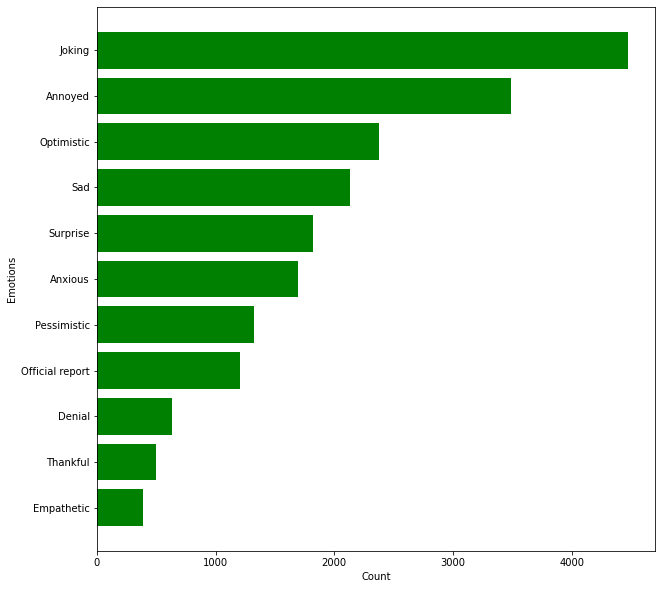

In [5]:
emotions = list(senwave.columns[2:])
scores = [sum(senwave[x]) for x in emotions]
pairs = []

for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))

pairs = sorted(pairs, key = lambda x : x[1], reverse = False)
emotions_sorted = []
scores_sorted = []

for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [6]:
ieee = ieee.dropna(axis = 0, how = 'any')

In [7]:
groups = []
for i in range(len(ieee)):
    dt = ieee.iloc[i]['month']
    if (dt >= "Mar 25") and (dt <= "Mar 31"):
        groups.append(0)
    elif (dt == "Apr 01") or (dt == "Apr 02"):
        groups.append(0)
    elif (dt >= "Apr 14") and (dt <= "Apr 21"):
        groups.append(1)
    elif (dt >= "May 01") and (dt <= "May 07"):
        groups.append(2)
    elif (dt >= "May 18") and (dt <= "May 23"):
        groups.append(3)
    elif (dt >= "Jun 01") and (dt <= "Jun 07"):
        groups.append(4)
    elif ((dt >= "Jun 22") and (dt <= "Jun 30")) or (dt == "Jul 01"):
        groups.append(5)
    elif (dt >= "Jul 02") and (dt <= "Jul 15"):
        groups.append(6)
    elif (dt >= "Jul 16") and (dt <= "Jul 31"):
        groups.append(7)
    elif (dt >= "Aug 01") and (dt <= "Aug 04"):
        groups.append(7)
    elif (dt >= "Aug 05") and (dt <= "Aug 18"):
        groups.append(8)
    elif ((dt >= "Aug 19") and (dt <= "Aug 31")) or (dt == "Sep 01"):
        groups.append(9)
    else:
        groups.append(10)

In [8]:
ieee['group'] = groups

In [9]:
ieee.head(10)

,tweet_id,tweet,sentiment_score,month,group
0,1242697733175226369,Meditation and mindfulness tips for coping wit...,0.125,Mar 25,0
1,1242701857253982208,Contribute to INDIA FIGHTS CORONA @ Gandhinaga...,0.0,Mar 25,0
2,1242697356249882626,@DelhiPolice @DCPEastDelhi @msisodia @AamAadmi...,0.0,Mar 25,0
3,1242694142242652160,#SSC_UFM_MAT_KARONA\n#Corona is slow poison #U...,0.033333333333333326,Mar 25,0
4,1242700536752701440,https://t.co/P7eQiq8tFa Mata Di \nDoston ise #...,0.6,Mar 25,0
5,1242695689483759616,@chintskap And my mum will be PhD in Corona vi...,0.0,Mar 25,0
6,1242701623509389312,"@funnyhammy @GauravPandhi Dumbo, it's the amou...",-0.125,Mar 25,0
7,1242696672745947136,. First they allowed Corona possessions. Now t...,0.08095238095238096,Mar 25,0
8,1242698536891760641,@TV9Marathi \nKindly help us to break the chai...,0.6,Mar 25,0
9,1242695871260758016,"When you are at safe at home, Corona is out bu...",0.3333333333333333,Mar 25,0


In [10]:
len(ieee)

159289

In [11]:
ieee.drop_duplicates(subset = 'tweet', keep = 'first', inplace = True)

In [12]:
len(ieee)

158941

In [13]:
group_scores = []
for i in range(ieee['group'].nunique()):
    subset = ieee[ieee['group'] == i]
    group_scores.append(sum(subset['sentiment_score'].astype(float).tolist())/len(subset))

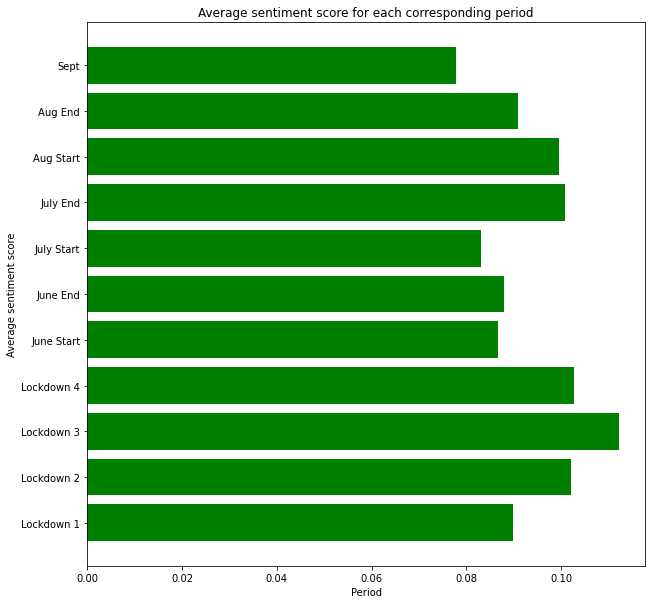

In [14]:
groups = ['Lockdown 1', 'Lockdown 2', 'Lockdown 3', 'Lockdown 4', 'June Start', 'June End', 'July Start', 'July End', 'Aug Start', 'Aug End', 'Sept']

fig = plt.figure(figsize = (10, 10))
plt.barh(groups, group_scores, color = 'green')
plt.xlabel("Period")
plt.ylabel("Average sentiment score")
plt.title("Average sentiment score for each corresponding period")
plt.show()

# **Lockdown 1**

In [15]:
ld1 = ieee[ieee['group'] == 0]
ld1.describe(include = 'all')

,tweet_id,tweet,sentiment_score,month,group
count,19695,19695,19695,19695,19695.0
unique,19695,19695,2535,9,NaN
top,1245162650373259265,"Hey Corona, I am home so enter at your own ris...",0.0,Mar 28,NaN
freq,1,1,6441,3115,NaN
mean,NaN,NaN,NaN,NaN,0.0
std,NaN,NaN,NaN,NaN,0.0
min,NaN,NaN,NaN,NaN,0.0
25%,NaN,NaN,NaN,NaN,0.0
50%,NaN,NaN,NaN,NaN,0.0
75%,NaN,NaN,NaN,NaN,0.0


In [18]:
ld1['sentiment_score'] = ld1['sentiment_score'].astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


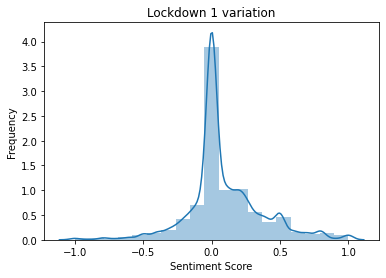

In [49]:
ax = sns.distplot(ld1['sentiment_score'], bins = 19)
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Lockdown 1 variation")
plt.show(ax)

Example from the lockdown 1

In [22]:
pos = ld1[ld1['sentiment_score'] == 1]
neu = ld1[ld1['sentiment_score'] == 0]
neg = ld1[ld1['sentiment_score'] == -1]

pos_rand = np.random.randint(0, len(pos))
neu_rand = np.random.randint(0, len(neu))
neg_rand = np.random.randint(0, len(neg))

print("Positive tweet : ", pos['tweet'].iloc[pos_rand], '\n', "Score : ", pos.iloc[pos_rand]['sentiment_score'], '\n\n\n')
print("Neutral tweet : ", neu['tweet'].iloc[neu_rand], '\n', "Score : ", neu.iloc[neu_rand]['sentiment_score'], '\n\n\n')
print("Negative tweet : ", neg['tweet'].iloc[neg_rand], '\n', "Score : ", neg.iloc[neg_rand]['sentiment_score'], '\n\n\n')

Positive tweet :  Very very proud of you @DCPSouthBCP https://t.co/JZ7gOOHFMt 
 Score :  1.0 



Neutral tweet :  #PMModi  I want to say that , the Number which is told Yesterday that's 9013151515 that not work .
I reply with Nam… https://t.co/BwqY0GNo9r 
 Score :  0.0 



Negative tweet :  Worst opposition in the world https://t.co/DC3s2FxJcP 
 Score :  -1.0 





# **Lockdown 2**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


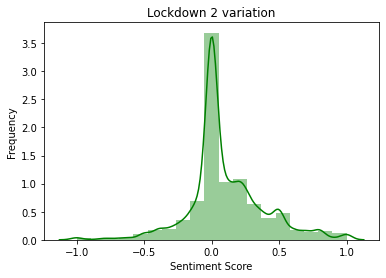

In [50]:
ld2 = ieee[ieee['group'] == 1]
ld2['sentiment_score'] = ld2['sentiment_score'].astype(float)
ax = sns.distplot(ld2['sentiment_score'], bins = 19, color = 'green')
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.title("Lockdown 2 variation")
plt.show(ax)

In [31]:
pos = ld2[ld2['sentiment_score'] == 1]
neu = ld2[ld2['sentiment_score'] == 0]
neg = ld2[ld2['sentiment_score'] == -1]

pos_rand = np.random.randint(0, len(pos))
neu_rand = np.random.randint(0, len(neu))
neg_rand = np.random.randint(0, len(neg))

print("Positive tweet : ", pos['tweet'].iloc[pos_rand], '\n', "Score : ", pos.iloc[pos_rand]['sentiment_score'], '\n\n\n')
print("Neutral tweet : ", neu['tweet'].iloc[neu_rand], '\n', "Score : ", neu.iloc[neu_rand]['sentiment_score'], '\n\n\n')
print("Negative tweet : ", neg['tweet'].iloc[neg_rand], '\n', "Score : ", neg.iloc[neg_rand]['sentiment_score'], '\n\n\n')

Positive tweet :  Best way to understand how india is controlling #Covid_19 https://t.co/NTyYI4BFzz 
 Score :  1.0 



Neutral tweet :  Question - I am facing confusion as a kid who needs to choose his life path and then corona happens.… https://t.co/jrHYwR5iWH 
 Score :  0.0 



Negative tweet :  Shocking https://t.co/fm5F44SN5E 
 Score :  -1.0 



